In [1]:
# %pip install google-cloud-bigquery==1.25.0
# %pip install google-resumable-media==0.6.0
# %pip install google-cloud-storage==1.30.0

In [2]:
# pip install -U google-cloud-bigquery google-api-core==1.33.2

In [3]:
BUCKET_list = !gcloud info --format='value(config.project)'
BUCKET=BUCKET_list[0]
!bq --location=US mk sparktobq
!bq --location=US load --autodetect --source_format=CSV sparktobq.kdd_cup_raw gs://$BUCKET/kddcup.data_10_percent.gz

BigQuery error in mk operation: Dataset 'qwiklabs-gcp-03-1aa4ca09e378:sparktobq'
already exists.
Waiting on bqjob_r48e8be476e493cb7_0000018d4e422196_1 ... (9s) Current status: DONE   


In [4]:
%%bigquery
SELECT * FROM sparktobq.kdd_cup_raw LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,int64_field_0,string_field_1,string_field_2,string_field_3,int64_field_4,int64_field_5,int64_field_6,int64_field_7,int64_field_8,int64_field_9,...,int64_field_32,double_field_33,double_field_34,double_field_35,double_field_36,double_field_37,double_field_38,double_field_39,double_field_40,string_field_41
0,25602,tcp,IRC,RSTR,3658,8518,0,0,0,0,...,12,0.31,0.08,0.03,0.0,0.00,0.00,0.31,1.00,normal.
1,6155,tcp,IRC,RSTO,1112,4968,0,0,0,0,...,8,0.50,0.12,0.06,0.0,0.00,0.00,0.44,0.88,normal.
2,0,tcp,IRC,SF,81,18,0,0,0,0,...,13,0.28,0.04,0.02,0.0,0.00,0.00,0.24,0.85,normal.
3,238,tcp,IRC,RSTO,132,1247,0,0,0,0,...,22,0.13,0.01,0.01,0.0,0.01,0.05,0.10,0.73,normal.
4,0,tcp,IRC,RSTO,0,0,0,0,0,0,...,23,0.13,0.01,0.01,0.0,0.01,0.04,0.10,0.74,normal.


In [5]:
%%bigquery

CREATE OR REPLACE TABLE sparktobq.kdd_cup AS

SELECT
    int64_field_0 AS duration,
    string_field_1 AS protocol_type,
    string_field_2 AS service,
    string_field_3 AS flag,
    int64_field_4 AS src_bytes,
    int64_field_5 AS dst_bytes,
    int64_field_6 AS wrong_fragment,
    int64_field_7 AS urgent,
    int64_field_8 AS hot,
    int64_field_9 AS num_failed_logins,
    int64_field_11 AS num_compromised,
    int64_field_13 AS su_attempted,
    int64_field_14 AS num_root,
    int64_field_15 AS num_file_creations,
    string_field_41 AS label
FROM
    sparktobq.kdd_cup_raw

Query is running:   0%|          |

""


In [6]:
%%bigquery
SELECT * FROM sparktobq.kdd_cup LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,su_attempted,num_root,num_file_creations,label
0,0,tcp,bgp,S0,0,0,0,0,0,0,0,0,0,0,neptune.
1,0,tcp,bgp,S0,0,0,0,0,0,0,0,0,0,0,neptune.
2,0,tcp,ctf,S0,0,0,0,0,0,0,0,0,0,0,neptune.
3,0,tcp,ctf,S0,0,0,0,0,0,0,0,0,0,0,neptune.
4,0,tcp,ctf,S0,0,0,0,0,0,0,0,0,0,0,neptune.


In [7]:
%%bigquery connections_by_protocol
SELECT COUNT(*) AS count
FROM sparktobq.kdd_cup
GROUP BY protocol_type
ORDER by count ASC

Query is running:   0%|          |

Downloading:   0%|          |

In [8]:
%%bigquery attack_stats
    SELECT
        protocol_type,
        CASE label
            WHEN 'normal.' THEN 'no attack'
            ELSE 'attack'
        END AS state,
        COUNT(*) as total_freq,
        ROUND(AVG(src_bytes), 2) as mean_src_bytes,
        ROUND(AVG(dst_bytes), 2) as mean_dst_bytes,
        ROUND(AVG(duration), 2) as mean_duration,
        SUM(num_failed_logins) as total_failed_logins,
        SUM(num_compromised) as total_compromised,
        SUM(num_file_creations) as total_file_creations,
        SUM(su_attempted) as total_root_attempts,
        SUM(num_root) as total_root_acceses
    FROM sparktobq.kdd_cup
    GROUP BY protocol_type, state
    ORDER BY 3 DESC

Query is running:   0%|          |

Downloading:   0%|          |

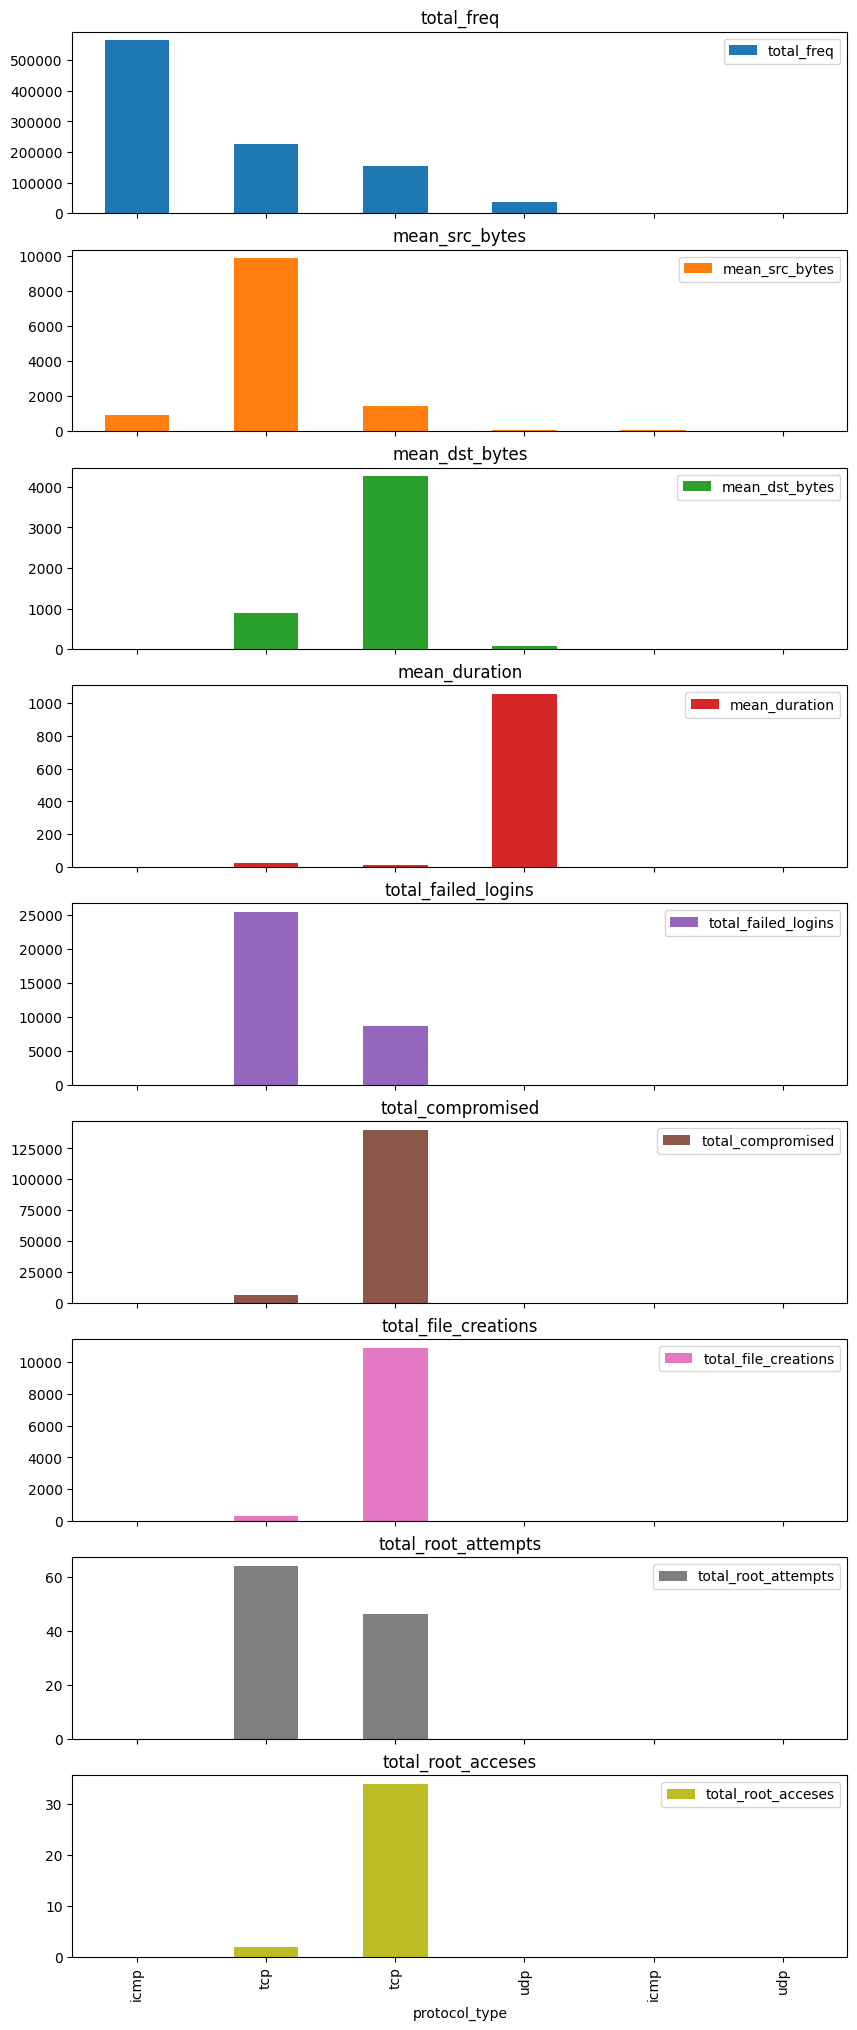

In [9]:
%matplotlib inline
ax = attack_stats.plot.bar(x='protocol_type', subplots=True, figsize=(10,25))

In [10]:
import google.cloud.storage as gcs

# save locally
ax[0].get_figure().savefig('report.png');
connections_by_protocol.to_csv("connections_by_protocol.csv")

# upload to GCS
bucket = gcs.Client().get_bucket(BUCKET)
for blob in bucket.list_blobs(prefix='sparktobq/'):
    blob.delete()
for fname in ['report.png', 'connections_by_protocol.csv']:
    bucket.blob('sparktobq/{}'.format(fname)).upload_from_filename(fname)